In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In this file, I want to understand the data I have. I will make simple visualisation charts to do so.  

From 01_data_cleaning_n_feature_engineering.ipynb, I have the following information:
- Number of unique clients : 1281
- Number of unique transactions : 25559
- Number of unique contracts : 1643
- Minimum payment amount : 0.01
- Maximum payment amount : 20050.04
- Transaction years: 2017-2018
- Years of Business establishment: 1999-2018

In [47]:
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 3 #change thickness to a higher value
font = {'family' : 'normal',
        'weight' : 'normal', #'bold'
        'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.markersize'] = 24

# Reading Clients data

First I load my cleaned clients data: 

In [48]:
clients = pd.read_csv("cleaned_data/clients.csv")
clients

,client_id,entity_type,entity_year_established
0,240,Australian Private Company,1999
1,11,Australian Private Company,1999
2,441,Australian Private Company,1999
3,895,Family Partnership,1999
4,557,Australian Private Company,1999
...,...,...,...
1276,1237,Individual/Sole Trader,2018
1277,1203,Individual/Sole Trader,2018
1278,1037,Australian Private Company,2018
1279,1198,Individual/Sole Trader,2018


I will now plot a pie chart to understand the relative distribution of the entity types. For this, I get the value_counts() for each entity_type. 

In [69]:
test = pd.DataFrame(clients[['entity_type']].value_counts(), columns=['count'])
test.to_clipboard()

I noted that the relative frequency of other entity_types beside Australian Private Company, Individual/Sole Trader and Family Partnership is quite low. Hence, I group them together into a group called "Others".

In [50]:
to_plot = test.iloc[:3]
others = test.iloc[3:].sum().to_frame().T
others.index = ['Others']
others.index.name = 'entity_type'
to_plot = pd.concat([to_plot.reset_index(), others.reset_index()]).set_index('entity_type')
to_plot

,count
entity_type,
Australian Private Company,750
Individual/Sole Trader,455
Family Partnership,39
Others,37


Now I plot my pie-chart:

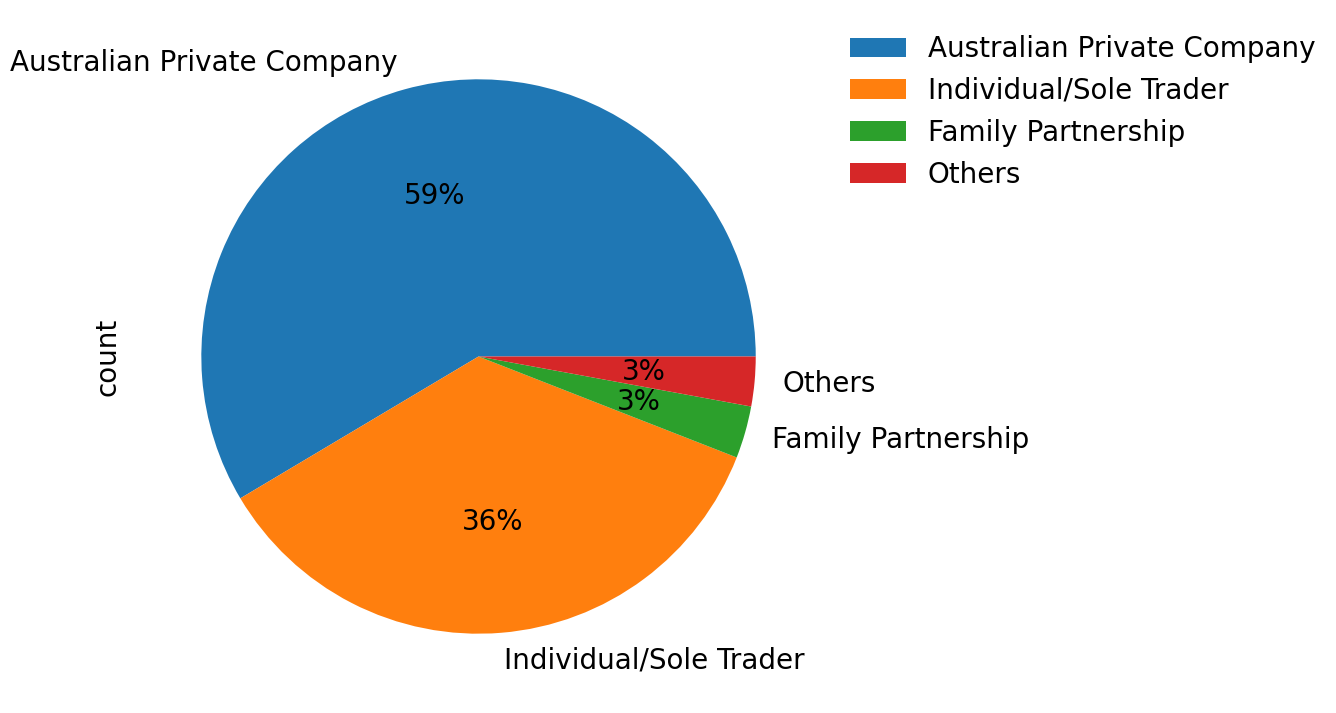

In [51]:
to_plot.plot.pie(y='count', autopct='%1.0f%%', figsize=[16,9])
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon=False)

# Reading combined data

Now I read my combined data from clients and payments. 

In [52]:
df = pd.read_csv("generated_data/final_df.csv", parse_dates=['transaction_date'])
df.head()

,client_id,entity_type,entity_year_established,transaction_id,contract_id,payment_amt,payment_code,transaction_date,transaction_year,transaction_month,years_from_establishment
0,240,Australian Private Company,1999,23556,1557,50.00,PAYMENT,2018-07-03 18:08:45,2018,2018-07,19
1,240,Australian Private Company,1999,23997,1557,1716.67,PAYMENT,2018-07-08 18:09:22,2018,2018-07,19
2,240,Australian Private Company,1999,23998,1557,64.99,PAYMENT,2018-07-08 18:09:22,2018,2018-07,19
3,240,Australian Private Company,1999,23555,1557,20050.04,PAYMENT,2018-07-03 18:08:45,2018,2018-07,19
4,11,Australian Private Company,1999,5009,220,199.99,PAYMENT,2017-09-24 18:08:12,2017,2017-09,18


### 2.1 Seasonal trends in the payment defaults

In [53]:
t1 = df.groupby(['transaction_month', 'payment_code'])['transaction_id'].count().unstack(-1)

monthly_defaults = 100*t1['DEFAULT'] / t1.sum(axis=1)
seasonal = pd.DataFrame(monthly_defaults.sort_values(ascending=False), columns=['default_percent']).reset_index()
seasonal.transaction_month = pd.to_datetime(seasonal.transaction_month)
seasonal.head()

,transaction_month,default_percent
0,2017-08-01,10.972143
1,2018-02-01,9.868766
2,2018-04-01,9.775429
3,2017-07-01,8.864119
4,2018-01-01,8.818813


<AxesSubplot:xlabel='Transaction month', ylabel='Default Percentage'>

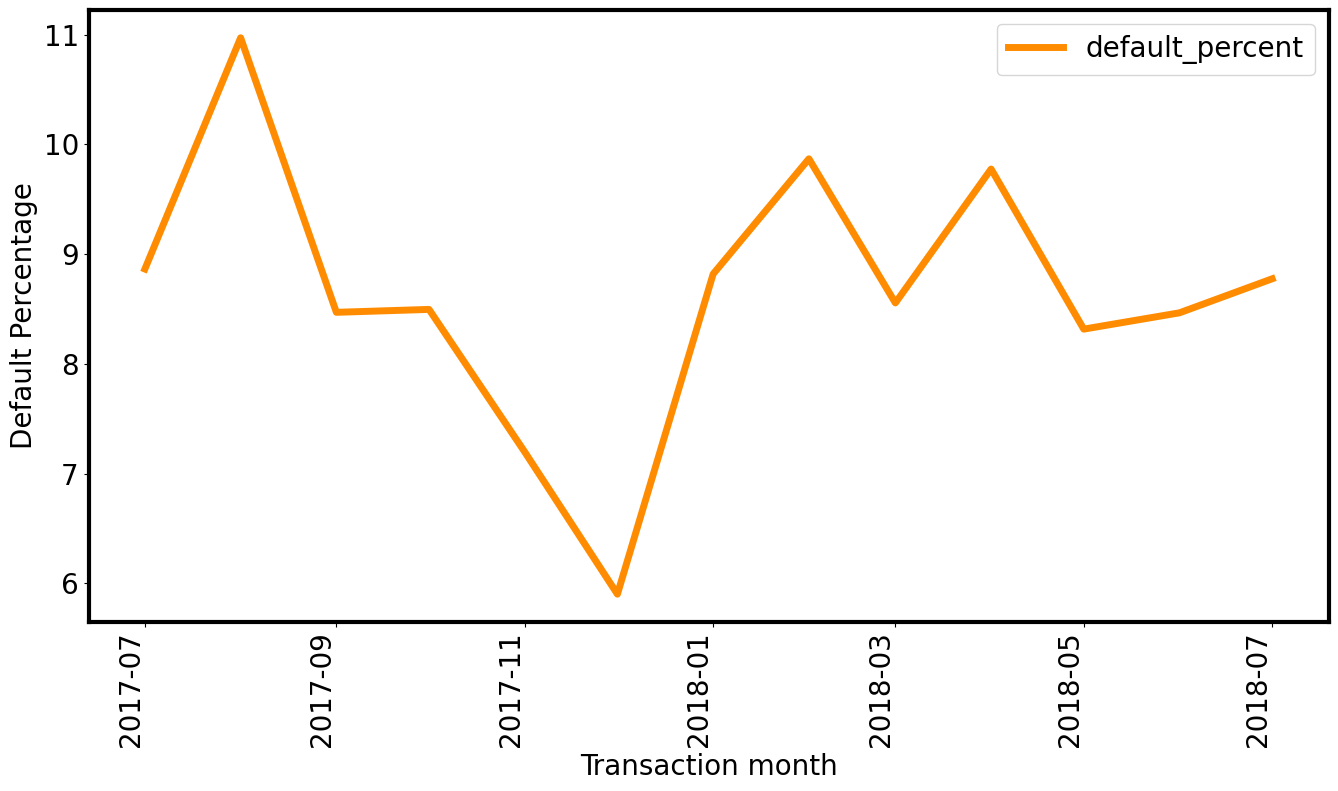

In [68]:
seasonal.to_clipboard()
seasonal.plot(x='transaction_month', y='default_percent', rot=90, xlabel = 'Transaction month',
              ylabel='Default Percentage', figsize=[16,9], linewidth=5, color='darkorange')


### 2.2 Who are the clients with most default payments per entity_type?

In [55]:
list_of_entities = df.entity_type.unique()#.to_list()
list_of_entities

array(['Australian Private Company', 'Family Partnership',
       'Individual/Sole Trader', 'Other Partnership',
       'Australian Public Company', 'Fixed Unit Trust',
       'Discretionary Trading Trust', 'Hybrid Trust',
       'Discretionary Investment Trust', 'Australian Proprietary Company'],
      dtype=object)

In [56]:
t1 = df.groupby(['entity_type','client_id', 'payment_code']).transaction_id.count().unstack(-1).fillna(0)
t1['default_proportions'] = t1['DEFAULT']/(t1['PAYMENT']+t1['DEFAULT'])
t1.groupby('entity_type').default_proportions.idxmax()

entity_type
Australian Private Company             (Australian Private Company, 644)
Australian Proprietary Company     (Australian Proprietary Company, 600)
Australian Public Company               (Australian Public Company, 714)
Discretionary Investment Trust    (Discretionary Investment Trust, 1195)
Discretionary Trading Trust          (Discretionary Trading Trust, 1076)
Family Partnership                             (Family Partnership, 791)
Fixed Unit Trust                                 (Fixed Unit Trust, 435)
Hybrid Trust                                         (Hybrid Trust, 582)
Individual/Sole Trader                     (Individual/Sole Trader, 610)
Other Partnership                              (Other Partnership, 1095)
Name: default_proportions, dtype: object

In [57]:
t1[t1.default_proportions >= 0.5].reset_index(level='client_id').groupby(['entity_type']).client_id.value_counts()

entity_type                 client_id
Australian Private Company  52           1
                            335          1
                            541          1
                            644          1
                            757          1
                            813          1
                            1011         1
Individual/Sole Trader      610          1
Other Partnership           1095         1
Name: client_id, dtype: int64

In [82]:
idoi= [
    52, 335,541,644,757,813,1011,610, 1095
]
df[(df['client_id'].isin(idoi)) & (df['payment_code'] == 'DEFAULT') ].groupby(['client_id', 'entity_type', 'entity_year_established', 'years_from_establishment']).payment_amt.sum()

client_id  entity_type                 entity_year_established  years_from_establishment
52         Australian Private Company  2013                     4                            117.68
335        Australian Private Company  2000                     18                          2188.22
541        Australian Private Company  2015                     2                            170.43
610        Individual/Sole Trader      2000                     17                             0.01
644        Australian Private Company  2008                     9                           3277.14
757        Australian Private Company  2015                     2                              0.01
813        Australian Private Company  2000                     17                            23.67
1011       Australian Private Company  2015                     2                           1457.56
1095       Other Partnership           2011                     6                             27.35
Name: payme

### 2.3 Which business types have the most defaults?

In [124]:
def plot_default_proportions(df = df, x = "entity_type", threshold4max = 0.05, plot_type = 'bar', x_label = "Business type", y_label = "Proportion of default payments"):
    df1 = df[[x, 'payment_code']]
    
    total = df1.groupby(x).count()
    defaults = df1[df1['payment_code']== "DEFAULT"].groupby(x).count()
    proportions = defaults/total

    # test = pd.DataFrame()

    colours = ['darkorange' if i >= max(proportions['payment_code'] - threshold4max*max(proportions['payment_code'])) else 'k' for i in proportions['payment_code']]
    proportions.reset_index(inplace=True)
    fig, ax = plt.subplots(1, 1, figsize=[16,8])
    proportions.pivot(columns=x, values='payment_code').plot(kind=plot_type,
                                                             legend= False, 
                                                             stacked=True, 
                                                             color=colours, 
                                                             ylabel= y_label,
                                                             xlabel= x_label,
                                                             ax=ax);
    proportions.to_clipboard()
    if plot_type == 'barh':
        ax.set_yticklabels(proportions[x]);
    else:
        ax.set_xticklabels(proportions[x]);
    


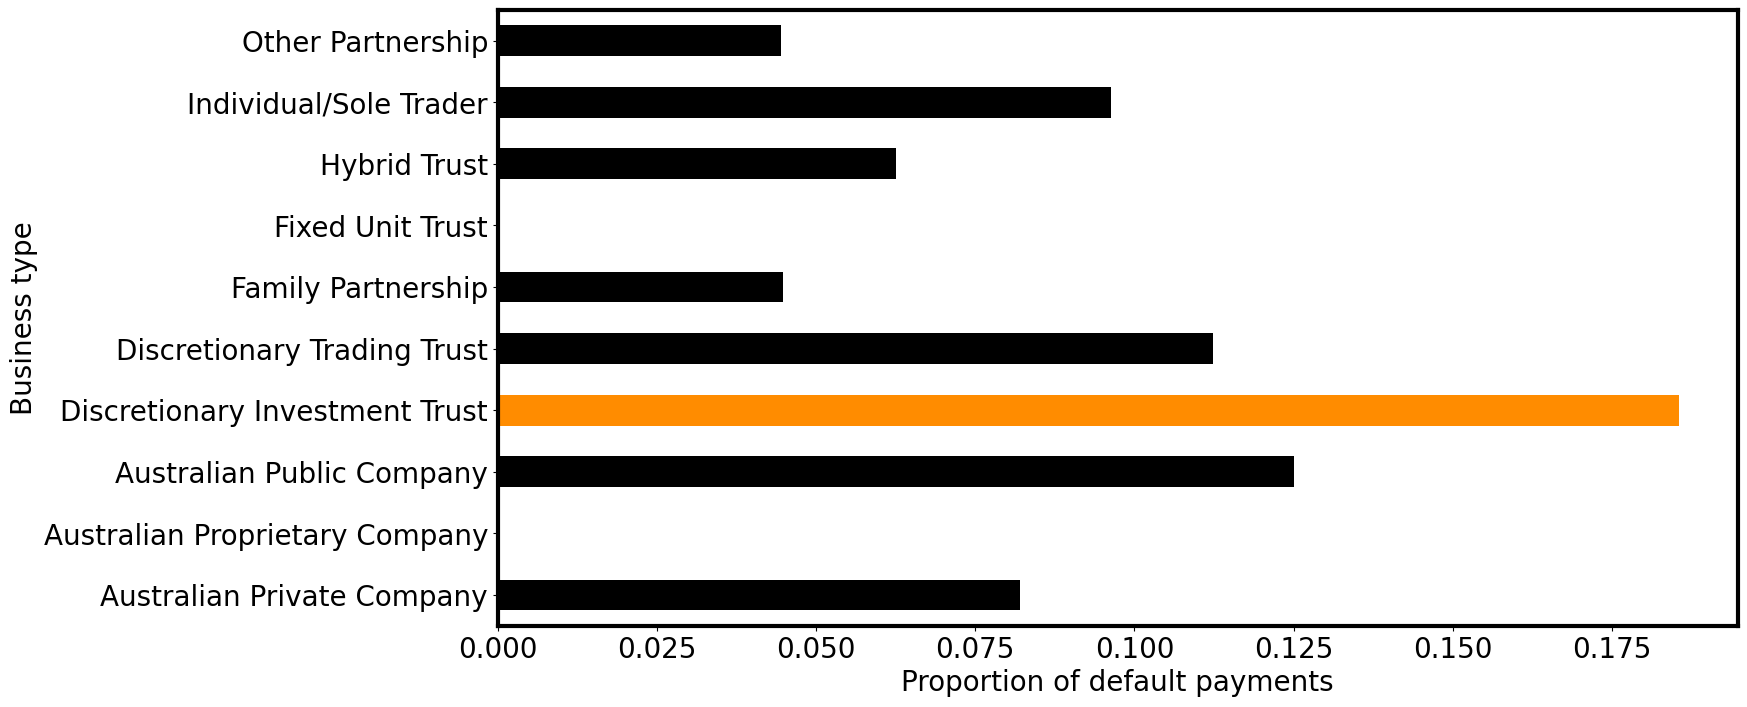

In [125]:
plot_default_proportions(plot_type = 'barh', x_label = "Proportion of default payments" , y_label = "Business type");

In [97]:
for col in df.select_dtypes(object):
    df[col] = df[col].str.strip()

In [105]:
x = df.query("payment_code == 'DEFAULT'").groupby('entity_type').payment_amt.sum().fillna(0)

In [106]:
y=df.query("payment_code == 'PAYMENT'").groupby('entity_type').payment_amt.sum().fillna(0)

In [115]:
x, y = x.align(y)
x

entity_type
Australian Private Company        956493.07
Australian Proprietary Company          NaN
Australian Public Company           7770.82
Discretionary Investment Trust    113763.57
Discretionary Trading Trust        18431.11
Family Partnership                 11268.34
Fixed Unit Trust                        NaN
Hybrid Trust                         900.00
Individual/Sole Trader            385726.14
Other Partnership                   2525.93
Name: payment_amt, dtype: float64

In [118]:
(x/(x+y)).to_clipboard()

In [119]:
(x.fillna(0)+y).to_clipboard()
# x

In [111]:
df[(df['entity_type']== 'Australian Private Company') & (df['payment_code'] == 'PAYMENT')].payment_amt.sum()

21411863.47

# Should we be wary of the year of the business's establishment?

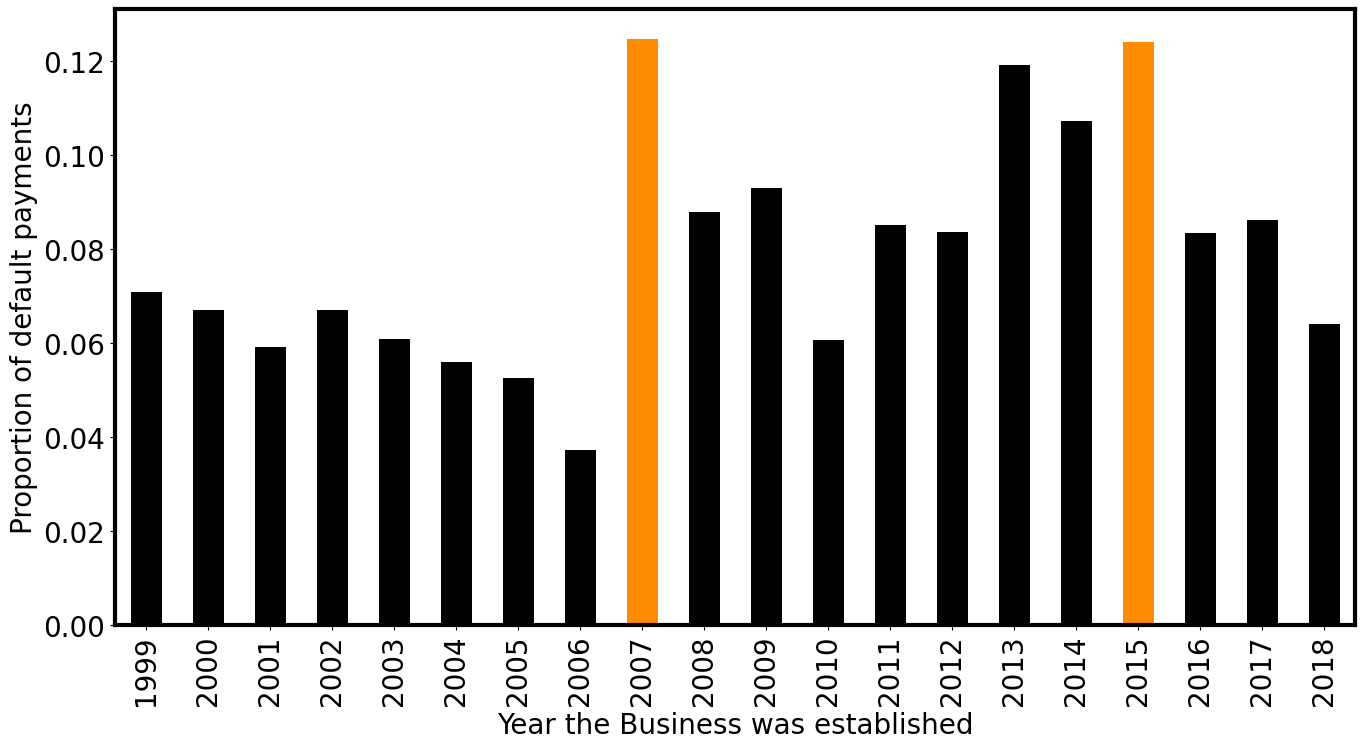

In [75]:
plot_default_proportions(x='entity_year_established', x_label= "Year the Business was established", threshold4max=0.02)

### Do age of the entity affect the payment defaults?

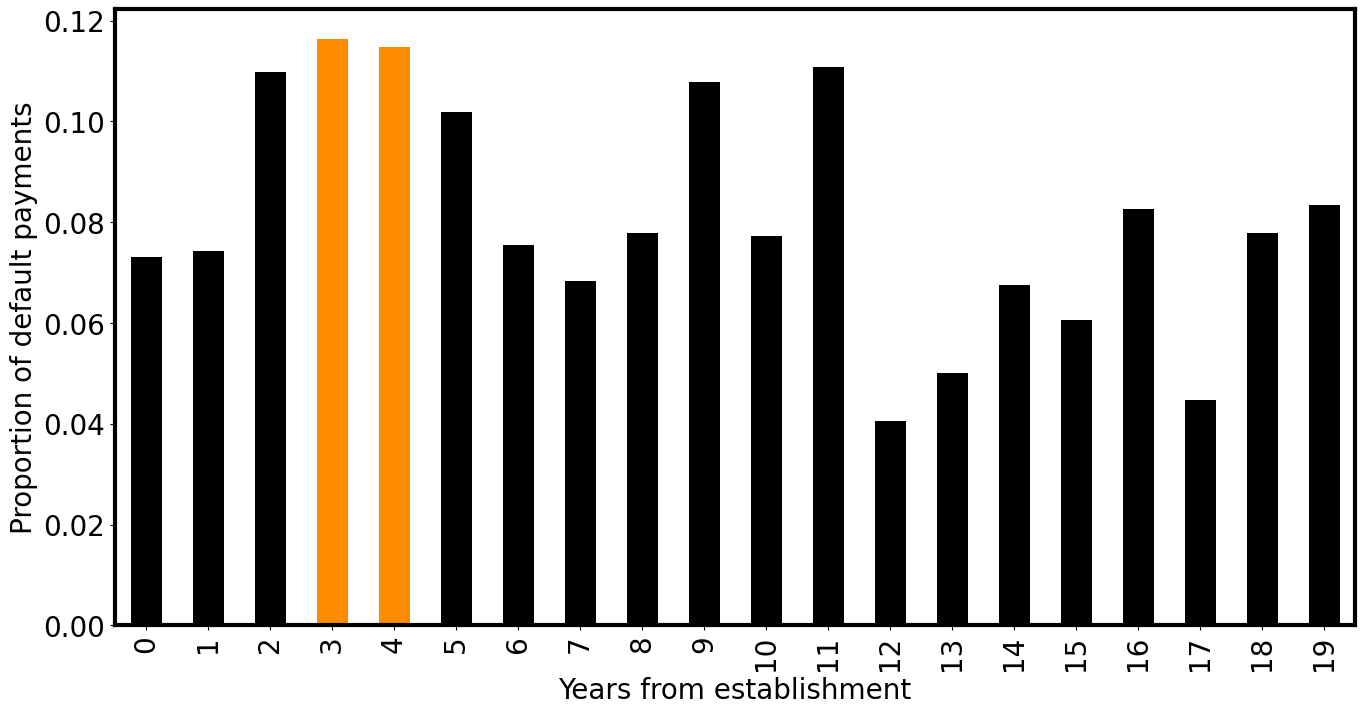

In [76]:
plot_default_proportions(df, x='years_from_establishment', x_label= 'Years from establishment', threshold4max=0.02)

# Payment amount distribution

In [78]:
# keep only data between 0.1 to 0.95 quantile ; 3 or 4 sigma data but use median to not aaffected by outliers
#distribution is heavily dominated by outliers so we cannot see the distribution. 
df.payment_amt.hist()
df[df['payment_code'] == 'DEFAULT'].payment_amt.hist(figsize=[16,9], label='Payment Defaults')
plt.xlabel("Payment amount (in AUD)")


SyntaxError: invalid syntax (722748754.py, line 5)

In [64]:
Q1 = df["payment_amt"].quantile(0.25)

Q3 = df["payment_amt"].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)

Upper_Fence = Q3 + (1.5 * IQR)

In [65]:
df_no_outliers = df[(Lower_Fence <df['payment_amt']) & (df['payment_amt'] < Upper_Fence)]
df_no_outliers

,client_id,entity_type,entity_year_established,transaction_id,contract_id,payment_amt,payment_code,transaction_date,transaction_year,transaction_month,years_from_establishment
0,240,Australian Private Company,1999,23556,1557,50.00,PAYMENT,2018-07-03 18:08:45,2018,2018-07,19
1,240,Australian Private Company,1999,23997,1557,1716.67,PAYMENT,2018-07-08 18:09:22,2018,2018-07,19
2,240,Australian Private Company,1999,23998,1557,64.99,PAYMENT,2018-07-08 18:09:22,2018,2018-07,19
4,11,Australian Private Company,1999,5009,220,199.99,PAYMENT,2017-09-24 18:08:12,2017,2017-09,18
6,11,Australian Private Company,1999,5008,220,1666.67,PAYMENT,2017-09-24 18:08:12,2017,2017-09,18
...,...,...,...,...,...,...,...,...,...,...,...
25551,125,Individual/Sole Trader,2018,20952,1415,133.33,PAYMENT,2018-06-03 18:08:34,2018,2018-06,0
25552,125,Individual/Sole Trader,2018,20951,1415,883.33,PAYMENT,2018-06-03 18:08:34,2018,2018-06,0
25553,125,Individual/Sole Trader,2018,23220,1415,133.33,PAYMENT,2018-06-28 18:08:46,2018,2018-06,0
25554,125,Individual/Sole Trader,2018,23219,1415,833.33,PAYMENT,2018-06-28 18:08:46,2018,2018-06,0


<AxesSubplot:>

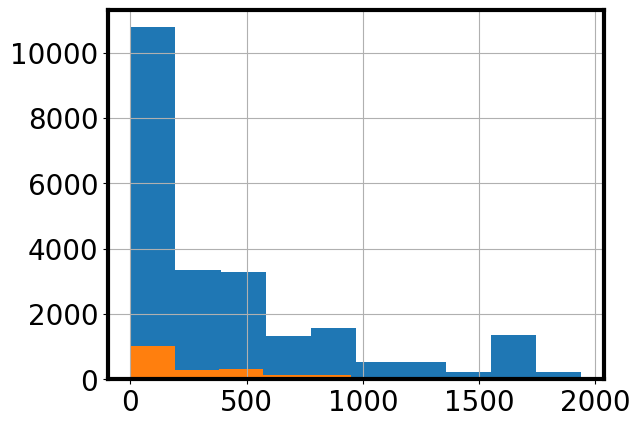

In [66]:
df_no_outliers.payment_amt.hist()
df_no_outliers[df_no_outliers['payment_code'] == 'DEFAULT'].payment_amt.hist()

/var/folders/3_/rdz4prgj2679t_ylmth_gwh00000gn/T/ipykernel_5213/1206513226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_payment['log_payment_amt'] = np.log10(log_payment['payment_amt'])


<AxesSubplot:>

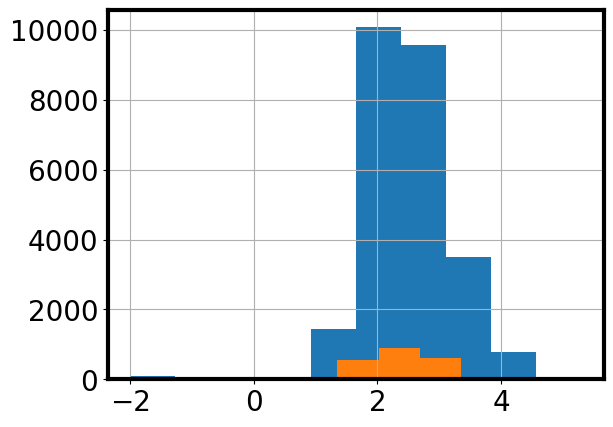

In [67]:
log_payment = df[['payment_amt', 'payment_code']]
log_payment['log_payment_amt'] = np.log10(log_payment['payment_amt'])
log_payment.log_payment_amt.hist()
log_payment[log_payment['payment_code'] == 'DEFAULT'].log_payment_amt.hist()

In [121]:
10**(log_payment.mean())

/var/folders/3_/rdz4prgj2679t_ylmth_gwh00000gn/T/ipykernel_5213/33674723.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  10**(log_payment.mean())


payment_amt               inf
log_payment_amt    291.848301
dtype: float64